In [2]:
!nvidia-smi

Fri Jan  3 08:30:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.08             Driver Version: 550.127.08     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L40S                    On  |   00000000:01:00.0 Off |                    0 |
| N/A   31C    P8             35W /  350W |       1MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
!mamba install -y -q pytorch~=2.0.0 torchvision pytorch-cuda=11.7 scikit-learn pyts h5py -c pytorch -c nvidia -c anaconda
!pip install -q pytorch-lightning torchmetrics

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... By downloading and using the CUDA Toolkit conda packages, you accept the terms and conditions of the CUDA End User License Agreement (EULA): https://docs.nvidia.com/cuda/eula/index.html

done


In [2]:
import h5py
import numpy as np
from pyts.image import RecurrencePlot
from pathlib import Path

SEED = 42
DATASET_PATH = './ukdale-processed.h5'

In [3]:
# Load data into memory
with h5py.File(DATASET_PATH, mode='r', swmr=True) as fp:
    X, y, activity = fp['X'][:], fp['y'][:], fp['activity'][:]

In [4]:
# Labels in the dataset are numerical. Let's create mapper to meaningful names.
mapper = {
    value: idx
    for idx, value in
    enumerate(['HEKA', 'HTPC', 'boiler', 'computer monitor', 'desktop computer', 'fridge/freezer', 'laptop computer', 'light', 'microwave', 'server computer', 'television', 'washer dryer'])
}
reverse_mapper = { v:k for k, v in mapper.items() }

In [5]:
# Check if the sizes and shapes are correct
print(f'{X.shape=} {X.dtype=};')
print(f'{y.shape=} {y.dtype=};')
print(f'{activity.shape=} {activity.dtype=};')

X.shape=(1275508, 600) X.dtype=dtype('float32');
y.shape=(1275508,) y.dtype=dtype('uint8');
activity.shape=(1275508,) activity.dtype=dtype('bool');


In [6]:
print(f'{len(X)=}')
print(f'{len(X[activity])=}')
print(f'{len(X[~activity])=}')

len(X)=1275508
len(X[activity])=319830
len(X[~activity])=955678


In [7]:
num_classes = int(1 + np.max(y))
num_classes

12

In [8]:
# Sanity check of recurrence plot transformation

rp = RecurrencePlot(dimension=0.501, threshold=None)

sample = X[0]
sample = sample.reshape(1, -1)  # Reshape (600,) to (1, 600)
sample_rp = rp.transform(sample)  # transforms into (1, 600, 600)
sample_rp = np.swapaxes(sample_rp, 0, -1) # Reshape into (600, 600, 1) to behave as an image for ToTensor
sample_rp = sample_rp.astype(np.float32)

print(X[0].shape, '--->', sample_rp.shape, sample_rp.dtype)

(600,) ---> (300, 300, 1) float32


In [9]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms as T
from torchvision.models import vgg11
import pytorch_lightning as pl
import torchmetrics

from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [10]:
class RecurrencePlotTransform:
    def __init__(self):
        self.rp = rp
    
    def __call__(self, sample):
        sample = sample.reshape(1, -1)  # Reshape (length,) to (1, length)
        sample_rp = self.rp.transform(sample)  # transforms into (1, length, length)
        sample_rp = np.swapaxes(sample_rp, 0, -1) # Reshape into (length, length, 1) to behave as an image for ToTensor
        sample_rp = sample_rp.astype(np.float32)
        return sample_rp
    

class DatasetAccessor(Dataset):
    def __init__(self, inputs, labels, transform=None):
        self.inputs = inputs
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        sample = self.inputs[idx]
        label = self.labels[idx]
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample, np.int64(label)
    
    
    
class Net(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.net = vgg11()  # VGG11 (without BN) as a backbone
        
        # Loss metric
        self.criterion = nn.CrossEntropyLoss()
        
        # Evaluation metrics to see progress
        self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #x = torch.abs(x[:, :, :, None] - x[:, :, None, :]) # TODO: recurrencePlot on GPU?
        x = self.net(x)
        return x
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        inputs, _ = batch
        logits = self(inputs)
        return logits
        
    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        logits = self(inputs)

        loss = self.criterion(logits, targets)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        logits = self(inputs)
        loss = self.criterion(logits, targets)
        self.log('val_loss', loss, prog_bar=True)
        
        # validation metrics
        predictions = torch.argmax(logits, dim=1)
        acc = self.accuracy(predictions, targets)
        self.log('val_acc', acc, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=3e-4)
        return optimizer

class Convert1to3channels:
    def __call__(self, x):
        return np.concatenate((x, x, x), axis=-1)
    
train_transform = T.Compose([
    RecurrencePlotTransform(), # time-series to recurrence plot transformation
    Convert1to3channels(), # To fulfill CNN requirement of having 3 channels
    T.ToTensor(),
])

In [11]:
indexes = np.arange(X.shape[0], dtype=int)

# Activity labels are the output of phase #1. The phase #2 does classification using DNN.
# Uncomment the following line to remove sparse samples. It will improve classification performance.
indexes = indexes[activity]

train_idx, test_idx = train_test_split(indexes, train_size=0.8, shuffle=True, random_state=SEED)

trainset = DatasetAccessor(inputs=X[train_idx], labels=y[train_idx], transform=train_transform)
testset = DatasetAccessor(inputs=X[test_idx], labels=y[test_idx], transform=train_transform)

# Sanity checks
assert trainset[0][0].shape == (3, 300, 300)

In [12]:
trainloader = DataLoader(
    trainset,
    batch_size=32,
    num_workers=32,
    shuffle=True,
    pin_memory=True,
    drop_last=False,
    prefetch_factor=16,
)

testloader = DataLoader(
    testset,
    batch_size=32,
    num_workers=32,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
    prefetch_factor=16,
)

In [13]:
# Optimization for GPU with Tensor cores
torch.set_float32_matmul_precision('medium')

pl.seed_everything(SEED)

net = Net()

# Initialize a trainer
trainer = pl.Trainer(
    benchmark=True, # Enable GPU specific optimizations
    max_epochs=32,
    accelerator='cpu',
    devices=1,
    #precision='bf16-mixed', 
    logger=False,
    enable_checkpointing=True,
)

# Train the model
#trainer.fit(net, trainloader, testloader)
net = Net.load_from_checkpoint('./checkpoints/epoch=14-step=29985.without-empty-samples.ckpt')

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
logits = trainer.predict(net, testloader)
logits = torch.concatenate(logits)

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

predictions = torch.argmax(logits, axis=1)

y_pred = predictions.numpy()
y_true = y[test_idx]

In [ ]:
# Help match predefined order in the paper.
label_names = '''
HEKA
fridge/freezer
HTPC
boiler
computer monitor
desktop computer
laptop computer
light
microwave
server computer
television
washer dryer
'''.split('\n')
label_names = list(filter(None, label_names))

In [ ]:
_y_pred = np.array([reverse_mapper[i] for i in y_pred])
_y_true = np.array([reverse_mapper[i] for i in y_true])

print(classification_report(_y_true, _y_pred, zero_division=0.0, labels=label_names, digits=4))

In [ ]:
probs = F.softmax(logits[:, :num_classes], dim=1).numpy()

for class_name in label_names:
    class_id = mapper[class_name]
    
    _probs = probs[:, class_id]
    
    score = roc_auc_score(y_true=(y_true==class_id), y_score=_probs, average='weighted')
    print(f'{score:.4f} :: {class_name}')

print(f"{roc_auc_score(y_true, probs, multi_class='ovr', average='weighted'):.4f} :: OVR + weighted average")

{0: 'HEKA', 1: 'HTPC', 2: 'boiler', 3: 'computer monitor', 4: 'desktop computer', 5: 'fridge/freezer', 6: 'laptop computer', 7: 'light', 8: 'microwave', 9: 'server computer', 10: 'television', 11: 'washer dryer'}


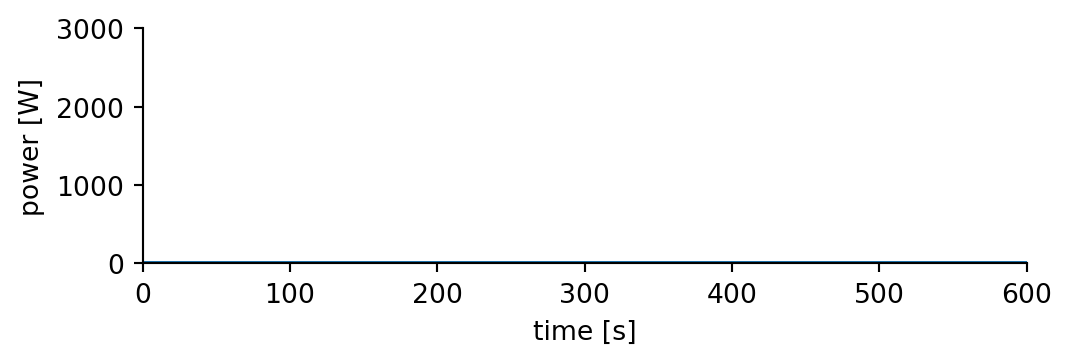

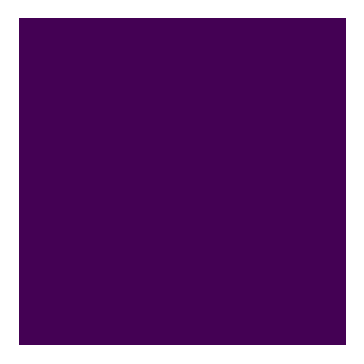

HEKA, no activity


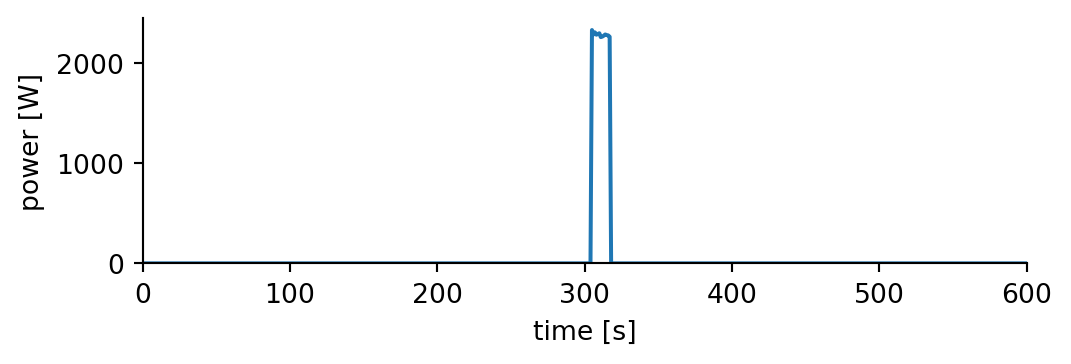

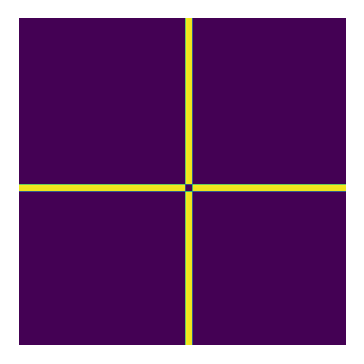

HEKA


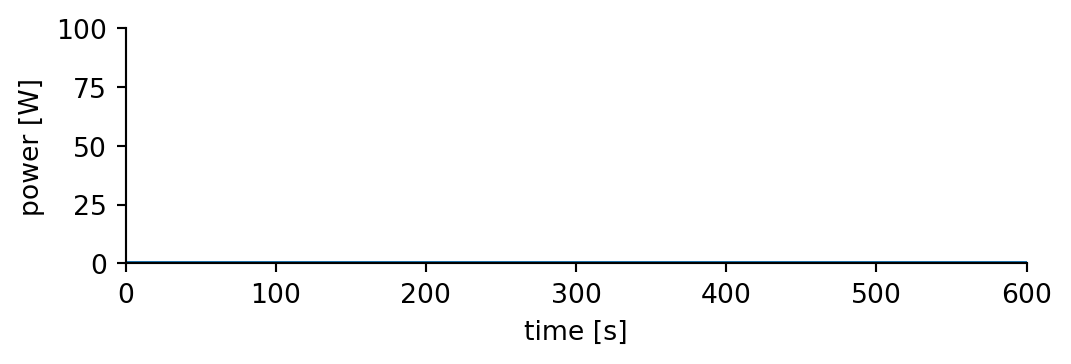

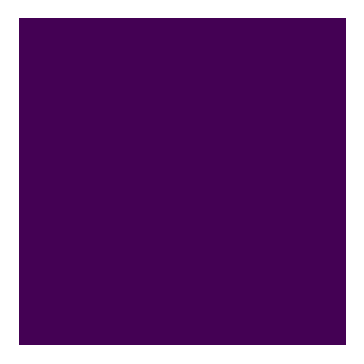

HTPC, no activity


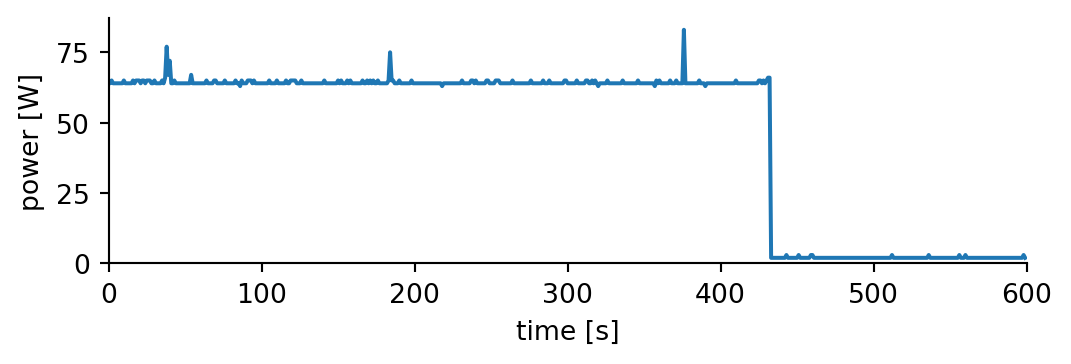

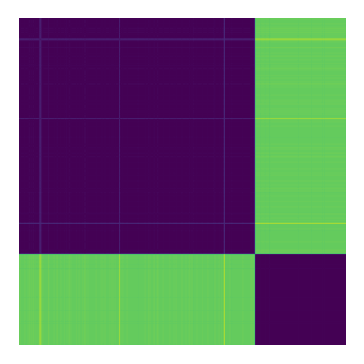

HTPC


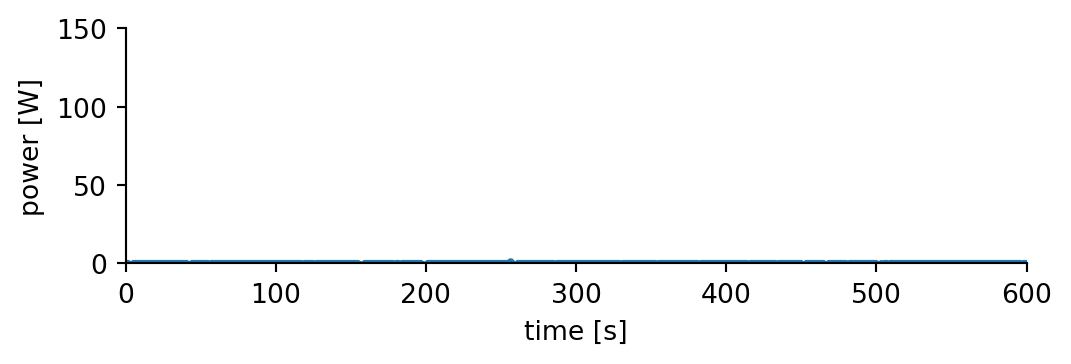

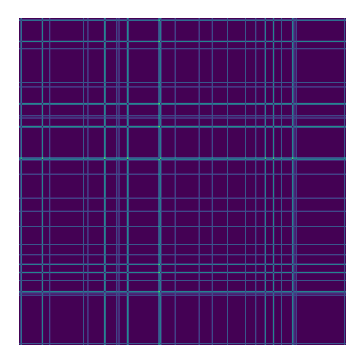

television, no activity


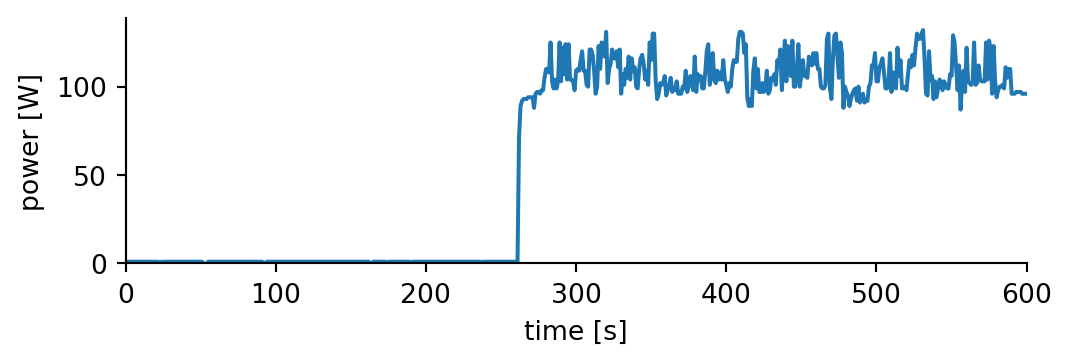

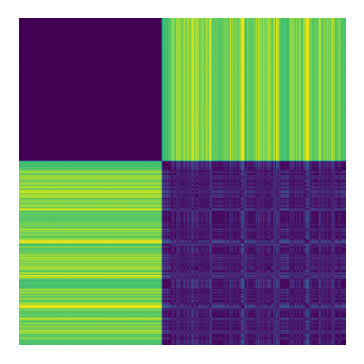

television


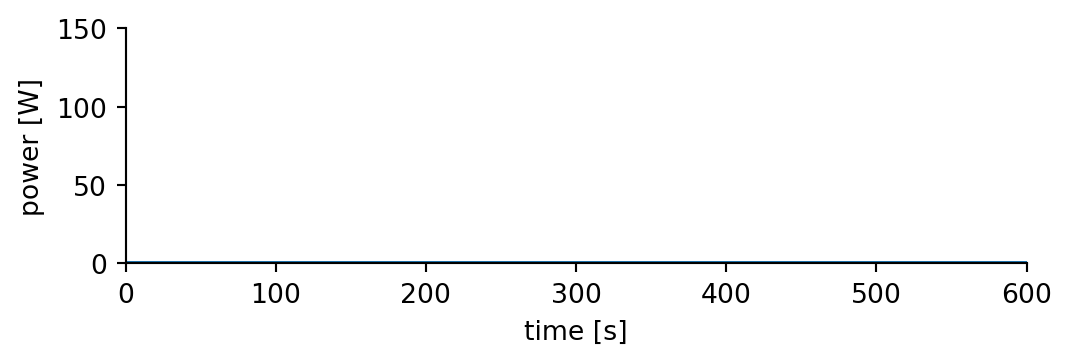

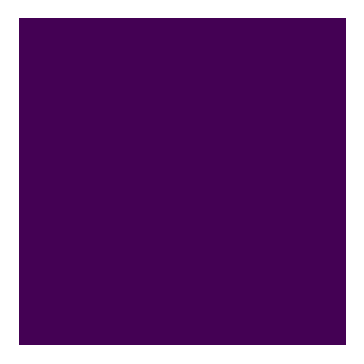

server computer, no activity


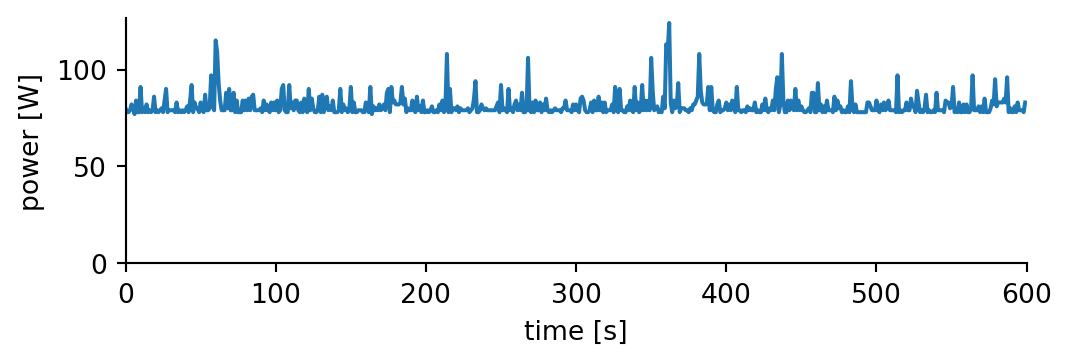

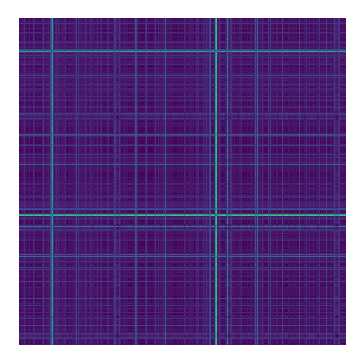

server computer


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

print(reverse_mapper)
rp = RecurrencePlot()


def plot_sample(sample, xlim=None, name:str='default'):
    fig, ax = plt.subplots(dpi=192, figsize=(7.1*4/5, 2), tight_layout=True)
    ax.plot(sample, label=name)
    ax.set_xlim(0, 600)
    ax.set_ylim(0, xlim)
    #ax.set_title(f'{reverse_mapper[label]}')
    ax.set_xlabel('time [s]')
    ax.set_ylabel('power [W]')
    sns.despine(fig, ax)
    plt.savefig(f'./{name}.png')
    plt.show()
    
    
    
    rp_sample = rp.transform(sample.reshape(1, -1)).squeeze()


    fig, ax = plt.subplots(dpi=192, figsize=(2,2), tight_layout=True)
    ax.imshow(rp_sample)
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.savefig(f'./{name}-recur.png')
    plt.show()
    

idx = 1
plot_sample(X[~activity & (y == mapper['HEKA'])][idx], 3000, name='HEKA-noact'); print('HEKA, no activity')
plot_sample(X[activity & (y == mapper['HEKA'])][idx], None, name='HEKA'); print('HEKA')

idx = 30
plot_sample(X[~activity & (y == mapper['HTPC'])][idx], 100, name='HTPC-noact'); print('HTPC, no activity')
plot_sample(X[activity & (y == mapper['HTPC'])][idx], None, name='HTPC'); print('HTPC')

idx = 31
plot_sample(X[~activity & (y == mapper['television'])][idx], 150, name='TV-noact'); print('television, no activity')
plot_sample(X[activity & (y == mapper['television'])][idx], None, name='TV'); print('television')

idx = 31
plot_sample(X[~activity & (y == mapper['server computer'])][idx], 150, name='server-noact'); print('server computer, no activity')
plot_sample(X[activity & (y == mapper['server computer'])][idx], None, name='server'); print('server computer')